# Читаем базу

In [1]:
import pandas as pd

In [2]:
base_5 = pd.ExcelFile('/content/drive/MyDrive/Системный Блок/пишу тебе/открытки базы/_Расшифровка открыток 5 (ярмарка проектов).xlsx')
base_5 = pd.read_excel(base_5, 'Открытки')
base_5 = base_5.rename(columns={' ': 'Номер открытки'})
base_5 = base_5[(~base_5['Pic_url_1'].isna()) & (~base_5['Номер открытки'].isna())]
base_5['Номер открытки'] = base_5['Номер открытки'].astype(int)
base_5 = base_5.sort_values(by='Номер открытки').reset_index().drop('index', axis=1)
base_5.head()

,Номер открытки,Pic_url_1,Pic_url_2,Разрешение на публикацию,Источник,Была ли открытка отправлена по почте,"Название коллекции (если вы хотите подпись на сайте). Например, личная коллекция Василия Иванова.","Комментарий или метаинформация. Укажите тут любую метаинформацию про открытку, которую считаете важной. Например, какое-то знание или история, которую нельзя восстановить по тексту открытки.",Заливщик,Разметчик,...,Почему интересна,Id поста на сайте,Дата заливки,Оценка,Сгенерированные заголовки,image_tag_1,image_tag_2,image_tag_3,image_tag_4,image_tag_5
0,215454,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,Разрешаю публикацию,Найдено в интернете,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,215460,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,Разрешаю публикацию,Найдено в интернете,NaN,NaN,NaN,NaN,Лыкова Елена (ЯП6),...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
2,215465,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,Разрешаю публикацию,Найдено в интернете,NaN,NaN,NaN,NaN,Кулешова Екатерина (ЯП6),...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
3,215485,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,Разрешаю публикацию,Найдено в интернете,NaN,NaN,NaN,NaN,Рафаилова Алина (ЯП6),...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
4,215496,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,Разрешаю публикацию,Найдено в интернете,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
base_5.shape

(5299, 64)

# Проверяем валидность ссылок на хранилище

In [4]:
base_5['Статус (распределено, в процессе, завершено, проблема)'].value_counts()

Проверено                                                 2878
Завершено                                                  855
Ожидает проверки                                           774
Распределено                                               352
Готово к расшифровке                                       186
Исключено/ дубликат                                        112
В процессе                                                  51
Помощь модератора/ иностранный язык                         34
Помощь модератора/ не разобрать слова в тексте              33
Исключено                                                   14
Исключено/ трудный почерк                                    7
Помощь модератора/ информация об изображении, открытке       2
Name: Статус (распределено, в процессе, завершено, проблема), dtype: int64

Добавляем данные с предыдущих проверок

In [7]:
url_validity_prev = pd.read_csv('/content/base_5_url_validity_28_05_2023.csv', index_col=0)
base_5 = base_5.merge(url_validity_prev, on=['Номер открытки', 'Pic_url_1', 'Pic_url_2'], how='left')

In [8]:
base_5['Pic_url_1_valid'].value_counts()

True    1275
Name: Pic_url_1_valid, dtype: int64

In [9]:
base_5['Pic_url_2_valid'].value_counts()

True    1275
Name: Pic_url_2_valid, dtype: int64

Проверить нужно открытки со статусом "Готово к расшифровке" и "Распределено", если еще не проверялись

In [5]:
import requests
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [11]:
def is_valid_url(url):
  try:
    response = requests.get(url)
    return response.status_code == 200
  except:
    return False

In [12]:
base_5['Pic_url_1_valid'] = base_5.progress_apply(
    lambda row: is_valid_url(row['Pic_url_1']) 
    if pd.isna(row['Pic_url_1_valid']) and row[
        'Статус (распределено, в процессе, завершено, проблема)'
        ] in ['Распределено', 'Готово к расшифровке'] or not row['Pic_url_1_valid']
    else row['Pic_url_1_valid'], 
    axis=1
)

base_5['Pic_url_2_valid'] = base_5.progress_apply(
    lambda row: is_valid_url(row['Pic_url_2']) 
    if pd.isna(row['Pic_url_2_valid']) and row[
        'Статус (распределено, в процессе, завершено, проблема)'
        ] in ['Распределено', 'Готово к расшифровке'] or not row['Pic_url_2_valid']
    else row['Pic_url_2_valid'], 
    axis=1
)

100%|██████████| 4523/4523 [00:01<00:00, 3605.74it/s]


Результат

In [13]:
base_5['Pic_url_1_valid'].value_counts()

True    1276
Name: Pic_url_1_valid, dtype: int64

In [14]:
base_5['Pic_url_2_valid'].value_counts()

True    1276
Name: Pic_url_2_valid, dtype: int64

In [ ]:
base_5[base_5['Pic_url_2_valid'] == False]

Сохраняем

In [16]:
base_5[[
    'Номер открытки', 'Pic_url_1', 'Pic_url_2', 'Pic_url_1_valid','Pic_url_2_valid'
    ]].to_csv('base_5_url_validity_28_05_2023.csv')

# Считаем хеши открыток

Оставляем только новые открытки, которые были найдены в интернете и еще не проверены --- статус "Ожидает проверки"

In [6]:
base_5 = base_5[base_5['Статус (распределено, в процессе, завершено, проблема)'] == 'Ожидает проверки']
base_5.shape

(774, 64)

In [7]:
!pip install imagehash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.5 MB/s eta 0:00:00


In [8]:
from bs4 import BeautifulSoup
import imagehash
from PIL import Image

In [9]:
def download(url_1, url_2):
    pic_1_content = requests.get(url_1).content
    pic_2_content = requests.get(url_2).content
    
    with open ('pic_1.jpg', 'wb') as pic_1_file:
        pic_1_file.write(pic_1_content)
    with open ('pic_2.jpg', 'wb') as pic_2_file:
        pic_2_file.write(pic_2_content)

In [10]:
def get_hashes():
    pic_1 = Image.open('pic_1.jpg')
    hash_1 = imagehash.dhash(pic_1)
    pic_2 = Image.open('pic_2.jpg')
    hash_2 = imagehash.dhash(pic_2)
    return str(hash_1), str(hash_2)

In [11]:
def calculate(row):
    url_1 = row['Pic_url_1']
    url_2 = row['Pic_url_2']
    # print(url_1, '\n', url_2)

    try:
      download(url_1, url_2)
      return get_hashes() 
    except:
      # print(row['Номер открытки'])
      # raise
      return 'error', 'error'

In [12]:
from tqdm import tqdm
tqdm.pandas()

Вычисление хешей (и попутная валидация ссылок)

In [13]:
base_5['calc_res'] = base_5.progress_apply(calculate, axis=1)

100%|██████████| 774/774 [08:39<00:00,  1.49it/s]


Обработка результатов

In [14]:
base_5['base'] = 5
base_5 = base_5[['base', 'Номер открытки', 'Pic_url_1', 'Pic_url_2', 'calc_res']]
base_5['hash_1'] = base_5['calc_res'].apply(lambda x: x[0])
base_5['hash_2'] = base_5['calc_res'].apply(lambda x: x[1])
base_5.head()

<ipython-input-14-35d703f382a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_5['hash_1'] = base_5['calc_res'].apply(lambda x: x[0])
<ipython-input-14-35d703f382a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_5['hash_2'] = base_5['calc_res'].apply(lambda x: x[1])


,base,Номер открытки,Pic_url_1,Pic_url_2,calc_res,hash_1,hash_2
4523,5,229325,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,"(80b09898d6fcbafe, baa6b6a2aaa2b292)",80b09898d6fcbafe,baa6b6a2aaa2b292
4524,5,229326,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,"(9e96a6868686b288, 9ab2a282e682b282)",9e96a6868686b288,9ab2a282e682b282
4525,5,229327,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,"(b28a8e86baae8e9a, aeaef6c69292a6a2)",b28a8e86baae8e9a,aeaef6c69292a6a2
4526,5,229328,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,"(f4dcccced2c6eed0, cadad8d8d2e8d2f2)",f4dcccced2c6eed0,cadad8d8d2e8d2f2
4527,5,229329,https://storage.yandexcloud.net/postcards-open...,https://storage.yandexcloud.net/postcards-open...,"(e0a68ab09292c2a2, 9a9298a8acc8a2b4)",e0a68ab09292c2a2,9a9298a8acc8a2b4


Проверка, что посчитались все хеши

In [15]:
base_5[['hash_1', 'hash_2']].isna().sum()

hash_1    0
hash_2    0
dtype: int64

In [16]:
base_5[(base_5['hash_1'] == 'error') | (base_5['hash_2'] == 'error')]

,base,Номер открытки,Pic_url_1,Pic_url_2,calc_res,hash_1,hash_2


Приводим к виду одна строка = одна картинка

In [17]:
base_5 = base_5.drop('calc_res', axis=1)
temp = base_5.copy()
temp = temp.drop(['Pic_url_1', 'hash_1'], axis=1).rename(
    columns={'Pic_url_2': 'Pic_url', 'hash_2': 'hash'})
temp['Pic'] = 2
base_5 = base_5.drop(['Pic_url_2', 'hash_2'], axis=1).rename(
    columns={'Pic_url_1': 'Pic_url', 'hash_1': 'hash'})
base_5['Pic'] = 1
base_5 = pd.concat([base_5, temp])
base_5.head()

,base,Номер открытки,Pic_url,hash,Pic
4523,5,229325,https://storage.yandexcloud.net/postcards-open...,80b09898d6fcbafe,1
4524,5,229326,https://storage.yandexcloud.net/postcards-open...,9e96a6868686b288,1
4525,5,229327,https://storage.yandexcloud.net/postcards-open...,b28a8e86baae8e9a,1
4526,5,229328,https://storage.yandexcloud.net/postcards-open...,f4dcccced2c6eed0,1
4527,5,229329,https://storage.yandexcloud.net/postcards-open...,e0a68ab09292c2a2,1


In [18]:
base_5.shape

(1548, 5)

In [19]:
base_5['Pic'].value_counts()

1    774
2    774
Name: Pic, dtype: int64

Сохраняем

In [20]:
base_5.to_csv('base_5_hashes_5.csv')

In [ ]:
base_5 = pd.read_csv('base_5_hashes_4.csv', index_col=0)
base_5.head()

,base,Номер открытки,Pic_url,hash,Pic
2145,5,226947,https://storage.yandexcloud.net/postcards-open...,f2fafca4b0babcc0,1
2146,5,226948,https://storage.yandexcloud.net/postcards-open...,ca8a8282ce96bab2,1
2147,5,226949,https://storage.yandexcloud.net/postcards-open...,cc221a2e2a22464a,1
2148,5,226950,https://storage.yandexcloud.net/postcards-open...,dedcdee2c6f4eec6,1
2149,5,226951,https://storage.yandexcloud.net/postcards-open...,c0968e8a8a828af0,1


In [23]:
base_5.shape

(1548, 5)

# Добавляем данные с предыдущих итераций обработки

In [21]:
df = pd.concat(
    [pd.read_csv('hash_database_full.csv', index_col=0),
     pd.read_csv('base_5_hashes_4.csv', index_col=0).rename(columns={'Номер открытки': 'ID'}),
     pd.read_csv('base_5_hashes_5.csv', index_col=0).rename(columns={'Номер открытки': 'ID'})
    ])
# df = pd.read_csv('hash_database_full.csv', index_col=0)
# df = pd.concat([df, base_5.rename(columns={'Номер открытки': 'ID'})])
df = df.reset_index().drop('index', axis=1)
df.head()

,base,ID,Pic,Pic_url,hash
0,1,0,1,https://forum.vgd.ru/file.php?fid=5476&key=0,806969715521b059
1,1,2,1,https://forum.vgd.ru/file.php?fid=5492&key=0,f4d8cc0ca543d6b6
2,1,3,1,https://forum.vgd.ru/file.php?fid=20890&key=19...,f1732b4d73511723
3,1,4,1,https://forum.vgd.ru/file.php?fid=20894&key=16...,b292ced8b3f2f2f2
4,1,5,1,https://forum.vgd.ru/file.php?fid=20895&key=90...,b8186ca4ae8a989a


In [22]:
df.shape

(68258, 5)

In [25]:
df['base'].value_counts()

3    20882
4    18178
1    14074
2     9928
5     5196
Name: base, dtype: int64

In [ ]:
df['Pic'].value_counts()

1    32877
2    32661
Name: Pic, dtype: int64

Есть даже одинаковые ссылки

In [ ]:
df['Pic_url'].value_counts().sort_values(ascending=False)[:25]

https://storage.yandexcloud.net/postcards-museums/detmuseum/alpy3.png                                      6
https://storage.yandexcloud.net/postcards-museums/detmuseum/alpy1.png                                      4
https://storage.yandexcloud.net/postcards-open-sources/conros1785.jpg                                      2
https://storage.yandexcloud.net/postcards/1BOhnJB64qVnZAO0QFqIBCEICdZ1YHChZ                                2
https://storage.yandexcloud.net/postcards-cropped/547_1.jpg                                                2
https://storage.yandexcloud.net/postcards-open-sources/Auction-134.jpg                                     2
https://storage.yandexcloud.net/postcards-open-sources/Auction-521.jpg                                     2
https://storage.yandexcloud.net/postcards-open-sources/Delcampe-978.jpg                                    2
https://storage.yandexcloud.net/postcards-open-sources/Delcampe-4449.jpg                                   2
https://storage.yan

In [26]:
df.to_csv('hash_database_full.csv')

# Ищем дубликаты

Создаем ВК-дерево

In [27]:
from pybktree_imagehash import BKTree, hamming_distance
import collections

In [28]:
Item = collections.namedtuple('Item', 'hash_value hash_db_index')

In [29]:
def item_distance(x, y):
  return hamming_distance(x.hash_value, y.hash_value)

In [30]:
tree = BKTree(item_distance, [Item(value, ind) for ind, value in enumerate(df['hash'].to_list())])
sorted(tree)[:10]

[Item(hash_value='0000000000000000', hash_db_index=18964),
 Item(hash_value='0000000000000000', hash_db_index=30732),
 Item(hash_value='0000000000000000', hash_db_index=30733),
 Item(hash_value='0000000000000000', hash_db_index=30736),
 Item(hash_value='0000000000000000', hash_db_index=30741),
 Item(hash_value='0000000000000000', hash_db_index=30747),
 Item(hash_value='0000000000000000', hash_db_index=30751),
 Item(hash_value='0000000000000000', hash_db_index=30757),
 Item(hash_value='0000000000000000', hash_db_index=30761),
 Item(hash_value='0000000000000000', hash_db_index=30763)]

Ищем объекты на расстоянии до 3 (только по новым открыткам)

In [31]:
from tqdm import tqdm

In [32]:
base_5_ids = base_5['Номер открытки'].to_list()
df_to_search = df[(df['base'] == 5) & (df['ID'].isin(base_5_ids))]
df_to_search.head()

,base,ID,Pic,Pic_url,hash
66710,5,229325,1,https://storage.yandexcloud.net/postcards-open...,80b09898d6fcbafe
66711,5,229326,1,https://storage.yandexcloud.net/postcards-open...,9e96a6868686b288
66712,5,229327,1,https://storage.yandexcloud.net/postcards-open...,b28a8e86baae8e9a
66713,5,229328,1,https://storage.yandexcloud.net/postcards-open...,f4dcccced2c6eed0
66714,5,229329,1,https://storage.yandexcloud.net/postcards-open...,e0a68ab09292c2a2


In [33]:
df_to_search.shape

(1548, 5)

In [34]:
possible_doubles = []
threshold = 3  # hamming distance threshold

for ind, row in tqdm(df_to_search.iterrows(), total=df_to_search.shape[0]):
    this_id = row.name
    this_hash = row['hash']
    search_results = sorted(tree.find(Item(this_hash, this_id), threshold))
    possible_doubles += [(t[0], this_id, t[1].hash_db_index) for t in search_results 
                         if t[1].hash_db_index != this_id]  # not the picture itself

100%|██████████| 1548/1548 [01:35<00:00, 16.21it/s]


In [35]:
possible_doubles = pd.DataFrame(possible_doubles, columns=[
    'hash_dist', 'hash_db_index_1', 'hash_db_index_2'])

In [36]:
possible_doubles.head()

,hash_dist,hash_db_index_1,hash_db_index_2
0,1,66762,50699
1,3,66762,66790
2,2,66763,53729
3,3,66790,66762
4,3,66798,67092


# Чистим и дополняем таблицу дубликатов

Удаляем дублирующиеся пары (типа 13, 14 и 14, 13). Таким образом, base_2 всегда будет больше base_1 (см. ниже)

In [37]:
possible_doubles['temp'] = possible_doubles.apply(
    lambda row: (min(row['hash_db_index_1'], row['hash_db_index_2']), 
                 max(row['hash_db_index_1'], row['hash_db_index_2'])),
    axis=1
)
possible_doubles['hash_db_index_1'] = possible_doubles['temp'].apply(lambda x: x[0])
possible_doubles['hash_db_index_2'] = possible_doubles['temp'].apply(lambda x: x[1])
possible_doubles = possible_doubles.drop('temp', axis=1)

possible_doubles = possible_doubles.drop_duplicates().reset_index().drop('index', axis=1)

In [38]:
possible_doubles.head()

,hash_dist,hash_db_index_1,hash_db_index_2
0,1,50699,66762
1,3,66762,66790
2,2,53729,66763
3,3,66798,67092
4,1,66876,66977


In [39]:
possible_doubles.shape

(81, 3)

Статистика по расстоянию

In [40]:
possible_doubles['hash_dist'].value_counts()

0    58
3    12
1     7
2     4
Name: hash_dist, dtype: int64

Добавляем в таблицу данные об изображениях

In [41]:
possible_doubles['base_1'] = possible_doubles['hash_db_index_1'].apply(lambda x: df.iloc[x]['base'])
possible_doubles['ID_1'] = possible_doubles['hash_db_index_1'].apply(lambda x: df.iloc[x]['ID'])
possible_doubles['Pic_1'] = possible_doubles['hash_db_index_1'].apply(lambda x: df.iloc[x]['Pic'])

possible_doubles['base_2'] = possible_doubles['hash_db_index_2'].apply(lambda x: df.iloc[x]['base'])
possible_doubles['ID_2'] = possible_doubles['hash_db_index_2'].apply(lambda x: df.iloc[x]['ID'])
possible_doubles['Pic_2'] = possible_doubles['hash_db_index_2'].apply(lambda x: df.iloc[x]['Pic'])

possible_doubles = possible_doubles[['hash_dist', 
                                     'hash_db_index_1', 'base_1', 'ID_1', 'Pic_1', 
                                     'hash_db_index_2', 'base_2', 'ID_2', 'Pic_2', 
                                     ]]
possible_doubles = possible_doubles.drop(['hash_db_index_1', 'hash_db_index_2'], axis=1)
possible_doubles.head()

,hash_dist,base_1,ID_1,Pic_1,base_2,ID_2,Pic_2
0,1,4,219139,1,5,229379,1
1,3,5,229379,1,5,229407,1
2,2,4,220412,1,5,229380,1
3,3,5,229415,1,5,229709,1
4,1,5,229493,1,5,229594,1


Статистика по базам

In [42]:
possible_doubles['base_1'].value_counts()

5    66
4     7
3     4
2     4
Name: base_1, dtype: int64

In [43]:
possible_doubles['base_2'].value_counts()

5    81
Name: base_2, dtype: int64

Добавляем ссылки на изображения

In [44]:
possible_doubles['Pic_url_1_front'] = possible_doubles.apply(
    lambda row: df[(df['base'] == row['base_1']) & (df['ID'] == row['ID_1']) & 
                   (df['Pic'] == 1)]['Pic_url'].iloc[0], 
                   axis=1
    )
possible_doubles['Pic_url_1_back'] = possible_doubles.apply(
    lambda row: df[(df['base'] == row['base_1']) & (df['ID'] == row['ID_1']) & 
                   (df['Pic'] == 2)]['Pic_url'].iloc[0], 
    axis=1
    )
possible_doubles['Pic_url_2_front'] = possible_doubles.apply(
    lambda row: df[(df['base'] == row['base_2']) & (df['ID'] == row['ID_2']) & 
                   (df['Pic'] == 1)]['Pic_url'].iloc[0], 
                   axis=1
    )
possible_doubles['Pic_url_2_back'] = possible_doubles.apply(
    lambda row: df[(df['base'] == row['base_2']) & (df['ID'] == row['ID_2']) & 
                   (df['Pic'] == 2)]['Pic_url'].iloc[0], 
                   axis=1
    )

In [45]:
possible_doubles.isna().sum()

hash_dist          0
base_1             0
ID_1               0
Pic_1              0
base_2             0
ID_2               0
Pic_2              0
Pic_url_1_front    0
Pic_url_1_back     0
Pic_url_2_front    0
Pic_url_2_back     0
dtype: int64

# Проставляем статус "Дубли"

Считаем дубликатами без проверки, если хотя бы одно из двух:
* расстояние 0 (хеши совпадают полностью)
* возможными дублями являются и лицевые, и оборотные стороны

In [46]:
possible_doubles_pics = possible_doubles.groupby(['ID_1', 'ID_2']).apply(
    lambda x: True if x.shape[0] == 2 else False
).reset_index(name='Pics')
possible_doubles_pics.head()

,ID_1,ID_2,Pics
0,101256,229530,False
1,104243,229512,False
2,104654,229540,False
3,104937,229716,False
4,205343,229427,False


In [47]:
possible_doubles = possible_doubles.merge(possible_doubles_pics,
                       on=['ID_1', 'ID_2'], 
                       how='left')

In [48]:
possible_doubles['Pics'].value_counts()

True     56
False    25
Name: Pics, dtype: int64

In [49]:
possible_doubles['Статус'] = possible_doubles.apply(
    lambda row: 'Дубли' if row['hash_dist'] == 0 or row['Pics'] == True else '',
    axis=1
)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(possible_doubles.head())

,hash_dist,base_1,ID_1,base_2,ID_2,Pic_url_1_front,Pic_url_1_back,Pic_url_2_front,Pic_url_2_back,1 лицевая,2 лицевая,1 оборотная,2 оборотная,Статус
0,0,3,207233,5,228556,https://storage.yandexcloud.net/postcards-open-sources/pugachev (155).jpg,https://storage.yandexcloud.net/postcards-open-sources/pugachev (156).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1621).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1622).jpg,,,,,Дубли
1,0,5,228642,5,228647,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1793).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1794).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1803).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1804).jpg,,,,,Дубли
2,0,5,228603,5,228604,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1715).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1716).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1717).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1718).jpg,,,,,Дубли
3,0,5,228569,5,228572,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1647).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1648).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1653).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1654).jpg,,,,,Дубли
4,0,5,228514,5,228515,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1537).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1538).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1539).jpg,https://storage.yandexcloud.net/postcards-open-sources/auction10 (1540).jpg,,,,,Дубли


Оставляем каждую пару открыток один раз

In [50]:
possible_doubles = possible_doubles.groupby(['ID_1', 'ID_2']).first().reset_index()

In [51]:
possible_doubles['Статус'].value_counts()

Дубли    30
         23
Name: Статус, dtype: int64

In [52]:
possible_doubles = possible_doubles.drop(['Pic_1', 'Pic_2', 'Pics'], axis=1)
possible_doubles['1 лицевая'] = ''
possible_doubles['2 лицевая'] = ''
possible_doubles['1 оборотная'] = ''
possible_doubles['2 оборотная'] = ''
possible_doubles = possible_doubles[['hash_dist', 'base_1', 'ID_1', 'base_2', 'ID_2', 'Pic_url_1_front',
       'Pic_url_1_back', 'Pic_url_2_front', 'Pic_url_2_back',
       '1 лицевая', '2 лицевая', '1 оборотная', '2 оборотная', 'Статус']]

In [53]:
possible_doubles.shape

(53, 14)

Отсортируем по возрастанию расстояния

In [54]:
possible_doubles = possible_doubles.sort_values(by='hash_dist').reset_index().drop('index', axis=1)

In [55]:
possible_doubles.to_csv('possible_doubles_base_5_5_prep.csv', index=False)

# Дубли проскочили проверку

## 223952, 100565, 100598

In [ ]:
df = pd.read_csv('hash_database_full.csv', index_col=0)
df.head()

,base,ID,Pic,Pic_url,hash
0,1,0,1,https://forum.vgd.ru/file.php?fid=5476&key=0,806969715521b059
1,1,2,1,https://forum.vgd.ru/file.php?fid=5492&key=0,f4d8cc0ca543d6b6
2,1,3,1,https://forum.vgd.ru/file.php?fid=20890&key=19...,f1732b4d73511723
3,1,4,1,https://forum.vgd.ru/file.php?fid=20894&key=16...,b292ced8b3f2f2f2
4,1,5,1,https://forum.vgd.ru/file.php?fid=20895&key=90...,b8186ca4ae8a989a


In [ ]:
df.shape

(64960, 5)

In [ ]:
hashes_223952 = df[df['ID'] == 223952]['hash'].to_list()
print(hashes_223952)
hashes_223952 = [imagehash.hex_to_hash(v) for v in hashes_223952]

['66e6b282a9e151e1', 'f0b8b8b2b2f2d2d2']


In [ ]:
hashes_100565 = df[df['ID'] == 100565]['hash'].to_list()
print(hashes_100565)
hashes_100565 = [imagehash.hex_to_hash(v) for v in hashes_100565]

['66e0b2ca0968d0d1', 'b1b9b9b2b2f2d2d2']


In [ ]:
hashes_100598 = df[df['ID'] == 100598]['hash'].to_list()
print(hashes_100598)
hashes_100598 = [imagehash.hex_to_hash(v) for v in hashes_100598]

['66c0b2cb0960d061', 'b0b999b232b29292']


In [ ]:
print(f"""
Разница хешей
100565 и 100598: лицевая {hashes_100565[0] - hashes_100598[0]}
                 оборотная {hashes_100565[1] - hashes_100598[1]}
223952 и 100565: лицевая {hashes_223952[0] - hashes_100565[0]} 
                 оборотная {hashes_223952[1] - hashes_100565[1]}
223952 и 100598: лицевая {hashes_223952[0] - hashes_100598[0]}
                 оборотная {hashes_223952[1] - hashes_100598[1]}
""")


Разница хешей
100565 и 100598: лицевая 6
                 оборотная 6
223952 и 100565: лицевая 13 
                 оборотная 4
223952 и 100598: лицевая 13
                 оборотная 8



## 223857 и 100634

In [ ]:
hashes_223857 = df[df['ID'] == 223857]['hash'].to_list()
print(hashes_223857)
hashes_223857 = [imagehash.hex_to_hash(v) for v in hashes_223857]

['4e8e83878181d086', 'b8f2f2aaaaaab282']


In [ ]:
hashes_100634 = df[df['ID'] == 100634]['hash'].to_list()
print(hashes_100634)
hashes_100634 = [imagehash.hex_to_hash(v) for v in hashes_100634]

['4f87838281009185', 'd6537becaaaa8892']


In [ ]:
print(f"""
Разница хешей
223857 и 100634: лицевая {hashes_223857[0] - hashes_100634[0]}
                 оборотная {hashes_223857[1] - hashes_100634[1]}
""")


Разница хешей
223857 и 100634: лицевая 11
                 оборотная 19



## 223730 и 100952

In [ ]:
hashes_223730 = df[df['ID'] == 223730]['hash'].to_list()
print(hashes_223730)
hashes_223730 = [imagehash.hex_to_hash(v) for v in hashes_223730]

['dca2b33232737666', 'a288b0b4e8a890f4']


In [ ]:
hashes_100952 = df[df['ID'] == 100952]['hash'].to_list()
print(hashes_100952)
hashes_100952 = [imagehash.hex_to_hash(v) for v in hashes_100952]

['d46131336b737367', '8080302448094915']


In [ ]:
print(f"""
Разница хешей
223730 и 100952: лицевая {hashes_223730[0] - hashes_100952[0]}
                 оборотная {hashes_223730[1] - hashes_100952[1]}
""")


Разница хешей
223730 и 100952: лицевая 15
                 оборотная 20



## flying_ship_1

In [ ]:
df = pd.read_csv('/content/delcampe_flying_ship_1.csv', index_col=0)
with pd.option_context('display.max_colwidth', None):
    display(df.head())

,ID,url
0,delcampe-flying_ship_1-0,https://delcampe.net/en_GB/collectables/postcards/congo-kinshasa-ex-zaire/belgian-congo-other/antique-postcard-1909s-africa-belgian-congo-missions-nun-with-children-1711036483.html
1,delcampe-flying_ship_1-1,https://delcampe.net/en_GB/collectables/postcards/madagascar/antique-postcard-1910s-africa-madagascar-some-lepers-from-ambohidratrimo-nun-1711036471.html
2,delcampe-flying_ship_1-2,https://delcampe.net/en_GB/collectables/postcards/russia/tsarist-russia-postcard-1902-elizabeth-boehm-bem-writer-tolstoy-yasnaya-polyana-rural-children-1708590526.html
3,delcampe-flying_ship_1-3,https://delcampe.net/en_GB/collectables/postcards/red-cross/rare-tsarist-russia-postcard-1914-artist-signed-bek-marmarcheva-red-cross-sister-of-mercy-nun-wwi-1708589620.html
4,delcampe-flying_ship_1-4,https://delcampe.net/en_GB/collectables/postcards/red-cross/rare-tsarist-russian-postcard-1915-by-makovsky-sister-of-mercy-white-angel-wwi-1708588687.html


In [ ]:
df.shape

(9600, 2)

In [ ]:
df['url_suffix'] = df['url'].apply(lambda x: x.split('/')[-1].replace('.html', ''))
df['lot_name'] = df['url_suffix'].apply(lambda x: '-'.join(x.split('-')[:-1]))
df['lot_number'] = df['url_suffix'].apply(lambda x: x.split('-')[-1])
with pd.option_context('display.max_colwidth', None):
    display(df.head())

,ID,url,lot_name,url_suffix,lot_number
0,delcampe-flying_ship_1-0,https://delcampe.net/en_GB/collectables/postcards/congo-kinshasa-ex-zaire/belgian-congo-other/antique-postcard-1909s-africa-belgian-congo-missions-nun-with-children-1711036483.html,antique-postcard-1909s-africa-belgian-congo-missions-nun-with-children,antique-postcard-1909s-africa-belgian-congo-missions-nun-with-children-1711036483,1711036483
1,delcampe-flying_ship_1-1,https://delcampe.net/en_GB/collectables/postcards/madagascar/antique-postcard-1910s-africa-madagascar-some-lepers-from-ambohidratrimo-nun-1711036471.html,antique-postcard-1910s-africa-madagascar-some-lepers-from-ambohidratrimo-nun,antique-postcard-1910s-africa-madagascar-some-lepers-from-ambohidratrimo-nun-1711036471,1711036471
2,delcampe-flying_ship_1-2,https://delcampe.net/en_GB/collectables/postcards/russia/tsarist-russia-postcard-1902-elizabeth-boehm-bem-writer-tolstoy-yasnaya-polyana-rural-children-1708590526.html,tsarist-russia-postcard-1902-elizabeth-boehm-bem-writer-tolstoy-yasnaya-polyana-rural-children,tsarist-russia-postcard-1902-elizabeth-boehm-bem-writer-tolstoy-yasnaya-polyana-rural-children-1708590526,1708590526
3,delcampe-flying_ship_1-3,https://delcampe.net/en_GB/collectables/postcards/red-cross/rare-tsarist-russia-postcard-1914-artist-signed-bek-marmarcheva-red-cross-sister-of-mercy-nun-wwi-1708589620.html,rare-tsarist-russia-postcard-1914-artist-signed-bek-marmarcheva-red-cross-sister-of-mercy-nun-wwi,rare-tsarist-russia-postcard-1914-artist-signed-bek-marmarcheva-red-cross-sister-of-mercy-nun-wwi-1708589620,1708589620
4,delcampe-flying_ship_1-4,https://delcampe.net/en_GB/collectables/postcards/red-cross/rare-tsarist-russian-postcard-1915-by-makovsky-sister-of-mercy-white-angel-wwi-1708588687.html,rare-tsarist-russian-postcard-1915-by-makovsky-sister-of-mercy-white-angel-wwi,rare-tsarist-russian-postcard-1915-by-makovsky-sister-of-mercy-white-angel-wwi-1708588687,1708588687


In [ ]:
df['lot_name'].nunique()

9429

In [ ]:
df['lot_number'].nunique()

9600

In [ ]:
lot_name_count = df.groupby('lot_name')['ID'].count().sort_values(ascending=False).reset_index().rename(
    columns={'ID': 'count'}
)
names_count_gt_1 = lot_name_count[lot_name_count['count'] > 1]['lot_name'].to_list()
names_count_gt_1[:10]

['vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space',
 'tsarist-russia-kishinev-photo-postcard-1909s-russian-opera-singer-star-leonid-sobinov',
 'tsarist-russia-zhabye-village-austria-hungary-postcard-1910s-artist-slasten-cossack-haidamaka-by-shevchenko',
 'tsarist-russia-unused-postcard-1909s-russian-writer-leo-tolstoy-at-work-in-his-cabinet',
 'tsarist-russia-postcard-1910s-grave-of-leo-tolstoy-in-yasnaya-polyana-artist-signed-i-gorelow',
 'tsarist-russia-photo-postcard-1909s-mephistopheles-feodor-chaliapin-shalyapin-russian-opera-singer',
 'vintage-ussr-russian-photo-postcard-1947-russian-ballet-star-galina-ulanova-in-giselle',
 'vintage-russian-ussr-postcard-1955-by-uzbekov-soviet-sport-tv-football-fans-grandfather-and-grandson',
 'tsarist-russia-postcard-1909s-great-russian-writer-anton-chekhov-anton-cehov',
 'vintage-russian-postcard-1967-russian-folk-tale-rooster-with-scythe-sun-mushroom-artist-ershov']

In [ ]:
df[df['lot_name'].isin(names_count_gt_1)].to_csv('flying_ship_1_names_count_gt_1.csv')

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(df[df['lot_name'] == 
    'vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space'])

,ID,url,lot_name,url_suffix,lot_number
2459,delcampe-flying_ship_1-2459,https://delcampe.net/en_GB/collectables/postcards/famous-people/famous-ladies/vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463231129.html,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463231129,1463231129
2460,delcampe-flying_ship_1-2460,https://delcampe.net/en_GB/collectables/postcards/famous-people/famous-ladies/vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463230562.html,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463230562,1463230562
2461,delcampe-flying_ship_1-2461,https://delcampe.net/en_GB/collectables/postcards/famous-people/famous-ladies/vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463230070.html,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463230070,1463230070
2462,delcampe-flying_ship_1-2462,https://delcampe.net/en_GB/collectables/postcards/famous-people/famous-ladies/vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463228303.html,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space,vintage-russian-postcard-1963-1st-woman-pilot-cosmonaut-valentina-tereshkova-astronaut-space-1463228303,1463228303


# Baseline метрики

## Читаем данные

In [ ]:
labels_df = pd.concat([
    pd.read_csv('/content/дублирование разметка база 4.csv'),
    pd.read_csv('/content/дублирование разметка база 5.csv'),
])
labels_df = labels_df[~labels_df['hash_dist'].isna()]
labels_df['hash_dist'] = labels_df['hash_dist'].astype(int)
labels_df['base_1'] = labels_df['base_1'].astype(int)
labels_df['ID_1'] = labels_df['ID_1'].astype(int)
labels_df['base_2'] = labels_df['base_2'].astype(int)
labels_df['ID_2'] = labels_df['ID_2'].astype(int)

labels_df = labels_df[['base_1', 'ID_1', 'base_2', 'ID_2', 'Статус']].rename(
    columns={'Статус': 'label'})

labels_df.head()

,base_1,ID_1,base_2,ID_2,label
0,1,1204,4,216471,Дубли
1,1,1205,4,216472,Дубли
2,1,2145,4,217037,Разные лицевая и оборот
3,1,3103,4,217941,Дубли
4,1,3104,4,217977,Дубли


In [ ]:
labels_df.shape

(3538, 5)

In [ ]:
labels_df['label'] = labels_df['label'].replace(
    'Лицевая совпадает, оборот отличается', 'Совпадает лицевая, оборот отличается')
labels_df['label'].value_counts()

Дубли                                   1984
Разные лицевая и оборот                 1368
Совпадает лицевая, оборот отличается     186
Name: label, dtype: int64

In [ ]:
hash_df = pd.read_csv('hash_database_full.csv', index_col=0)
hash_df.head()

,base,ID,Pic,Pic_url,hash
0,1,0,1,https://forum.vgd.ru/file.php?fid=5476&key=0,806969715521b059
1,1,2,1,https://forum.vgd.ru/file.php?fid=5492&key=0,f4d8cc0ca543d6b6
2,1,3,1,https://forum.vgd.ru/file.php?fid=20890&key=19...,f1732b4d73511723
3,1,4,1,https://forum.vgd.ru/file.php?fid=20894&key=16...,b292ced8b3f2f2f2
4,1,5,1,https://forum.vgd.ru/file.php?fid=20895&key=90...,b8186ca4ae8a989a


Добавляем в таблицу разметки хеши лицевой и оборотной стороны

In [ ]:
# ID_1 Pic=1
labels_df = labels_df.merge(
    hash_df[hash_df['Pic'] == 1].rename(
        columns={'ID': 'ID_1', 'base': 'base_1', 'hash': 'ID_1_Pic_1_hash'}
        )[['base_1', 'ID_1', 'ID_1_Pic_1_hash']], 
    on=['base_1', 'ID_1'], how='left')

# ID_1 Pic=2
labels_df = labels_df.merge(
    hash_df[hash_df['Pic'] == 2].rename(
        columns={'ID': 'ID_1', 'base': 'base_1', 'hash': 'ID_1_Pic_2_hash'}
        )[['base_1', 'ID_1', 'ID_1_Pic_2_hash']], 
    on=['base_1', 'ID_1'], how='left')

# ID_2 Pic=1
labels_df = labels_df.merge(
    hash_df[hash_df['Pic'] == 1].rename(
        columns={'ID': 'ID_2', 'base': 'base_2', 'hash': 'ID_2_Pic_1_hash'}
        )[['base_2', 'ID_2', 'ID_2_Pic_1_hash']], 
    on=['base_2', 'ID_2'], how='left')

# ID_2 Pic=2
labels_df = labels_df.merge(
    hash_df[hash_df['Pic'] == 2].rename(
        columns={'ID': 'ID_2', 'base': 'base_2', 'hash': 'ID_2_Pic_2_hash'}
        )[['base_2', 'ID_2', 'ID_2_Pic_2_hash']], 
    on=['base_2', 'ID_2'], how='left')

In [ ]:
labels_df.head()

,base_1,ID_1,base_2,ID_2,label,ID_1_Pic_1_hash,ID_1_Pic_2_hash,ID_2_Pic_1_hash,ID_2_Pic_2_hash
0,1,1204,4,216471,Дубли,19f179593171d1b1,11971621f9e5ed4d,19f179593171d1b1,11971621f9e5ed4d
1,1,1205,4,216472,Дубли,f179717131716f71,3565454765714f3f,f179717131716f71,3565454765714f3f
2,1,2145,4,217037,Разные лицевая и оборот,4965312101010303,0000000000000000,0349333303070f03,0000000000000000
3,1,3103,4,217941,Дубли,61511507094d6101,094165655151495d,61511507094d6101,094165655151495d
4,1,3104,4,217977,Дубли,4d4dc94f47591945,494f774949596945,4d4dc94f47591945,494f774949596945


In [ ]:
labels_df.isna().sum()

base_1               0
ID_1                 0
base_2               0
ID_2                 0
label                0
ID_1_Pic_1_hash     95
ID_1_Pic_2_hash     96
ID_2_Pic_1_hash    126
ID_2_Pic_2_hash    126
dtype: int64

Исключаем строки, где хеш неизвестен

In [ ]:
labels_df = labels_df[
    ~(labels_df['ID_1_Pic_1_hash'].isna()) & 
    ~(labels_df['ID_1_Pic_2_hash'].isna()) &
    ~(labels_df['ID_2_Pic_1_hash'].isna()) & 
    ~(labels_df['ID_2_Pic_2_hash'].isna())
    ]
labels_df.shape

(3342, 9)

Добавляем попарные расстояния между хешами

In [ ]:
labels_df['hash_dist_pic_1'] = labels_df.apply(
    lambda row: hamming_distance(row['ID_1_Pic_1_hash'], row['ID_2_Pic_1_hash']),
    axis=1
)

labels_df['hash_dist_pic_2'] = labels_df.apply(
    lambda row: hamming_distance(row['ID_1_Pic_2_hash'], row['ID_2_Pic_2_hash']),
    axis=1
)

labels_df.head()

,base_1,ID_1,base_2,ID_2,label,ID_1_Pic_1_hash,ID_1_Pic_2_hash,ID_2_Pic_1_hash,ID_2_Pic_2_hash,hash_dist_pic_1,hash_dist_pic_2
0,1,1204,4,216471,Дубли,19f179593171d1b1,11971621f9e5ed4d,19f179593171d1b1,11971621f9e5ed4d,0,0
1,1,1205,4,216472,Дубли,f179717131716f71,3565454765714f3f,f179717131716f71,3565454765714f3f,0,0
2,1,2145,4,217037,Разные лицевая и оборот,4965312101010303,0000000000000000,0349333303070f03,0000000000000000,14,0
3,1,3103,4,217941,Дубли,61511507094d6101,094165655151495d,61511507094d6101,094165655151495d,0,0
4,1,3104,4,217977,Дубли,4d4dc94f47591945,494f774949596945,4d4dc94f47591945,494f774949596945,0,0


## Добавляем разметку


Исключаем автоматическую разметку

In [ ]:
def is_auto_label(ID_2, base_2, hash_dist_pic_1, hash_dist_pic_2):
  if ID_2 <= 220134 or base_2 == 5:
    return False
  if hash_dist_pic_1 == 0 or hash_dist_pic_2 == 0:
    return True
  if hash_dist_pic_1 <= 3 and hash_dist_pic_2 <= 3:
    return True
  return False

In [ ]:
labels_df['auto_label'] = labels_df.apply(
    lambda row: is_auto_label(row['ID_2'], row['base_2'], 
                              row['hash_dist_pic_1'], 
                              row['hash_dist_pic_2']),
    axis=1
)
labels_df['auto_label'].value_counts()

False    2268
True     1074
Name: auto_label, dtype: int64

In [ ]:
labels_df = labels_df[~labels_df['auto_label']]
labels_df.shape

(2268, 12)

Переводим разметку в True/False для лицевой и оборотной стороны

In [ ]:
labels_df['label'].value_counts()

Разные лицевая и оборот                 1244
Дубли                                    857
Совпадает лицевая, оборот отличается     167
Name: label, dtype: int64

In [ ]:
labels_df['truth_pic_1'] = labels_df['label'].apply(
    lambda x: x == 'Дубли' or x == 'Совпадает лицевая, оборот отличается'
)
labels_df['truth_pic_2'] = labels_df['label'].apply(
    lambda x: x == 'Дубли'
)
labels_df['truth_postcard'] = labels_df['label'].apply(
    lambda x: x == 'Дубли'
)

Добавляем столбец предсказаний

In [ ]:
labels_df['pred_pic_1'] = labels_df['hash_dist_pic_1'].apply(
    lambda x: x <= 3
)

labels_df['pred_pic_2'] = labels_df['hash_dist_pic_2'].apply(
    lambda x: x <= 3
)

labels_df['pred_postcard'] = labels_df.apply(
    lambda row: row['hash_dist_pic_1'] <= 3 or row['hash_dist_pic_2'] <= 3,
    axis=1
)

In [ ]:
labels_df['pred_postcard'].value_counts()

True     2221
False      47
Name: pred_postcard, dtype: int64

False есть из-за того, что кое-где лицевая сторона дублировала оборотную (с расстоянием 1), и это попало в таблицу, хотя не должно было

Берем часть датасета, где вся разметка была ручной

In [ ]:
hand_labels_df = labels_df[(labels_df['ID_2'] <= 220134) | (labels_df['base_2'] == 5)]
hand_labels_df.shape

(1238, 17)

In [ ]:
hand_labels_df['pred_postcard'].value_counts()

True     1224
False      14
Name: pred_postcard, dtype: int64

In [ ]:
1238 * 2

2476

## Датасет

Ручная разметка

In [14]:
hand_labels_df = hand_labels_df[['base_1', 'ID_1', 'base_2', 'ID_2', 
                                 'ID_1_Pic_1_hash', 'ID_1_Pic_2_hash',
                                 'ID_2_Pic_1_hash', 'ID_2_Pic_2_hash',
                                 'hash_dist_pic_1', 'hash_dist_pic_2',
                                 'truth_postcard', 'pred_postcard']]
hand_labels_df['is_auto_labelled'] = False
hand_labels_df.head()

<ipython-input-14-c8c7f23f104f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand_labels_df['is_auto_labelled'] = False


,base_1,ID_1,base_2,ID_2,ID_1_Pic_1_hash,ID_1_Pic_2_hash,ID_2_Pic_1_hash,ID_2_Pic_2_hash,hash_dist_pic_1,hash_dist_pic_2,truth_postcard,pred_postcard,is_auto_labelled
0,1,1204,4,216471,19f179593171d1b1,11971621f9e5ed4d,19f179593171d1b1,11971621f9e5ed4d,0,0,True,True,False
1,1,1205,4,216472,f179717131716f71,3565454765714f3f,f179717131716f71,3565454765714f3f,0,0,True,True,False
2,1,2145,4,217037,4965312101010303,0000000000000000,0349333303070f03,0000000000000000,14,0,False,True,False
3,1,3103,4,217941,61511507094d6101,094165655151495d,61511507094d6101,094165655151495d,0,0,True,True,False
4,1,3104,4,217977,4d4dc94f47591945,494f774949596945,4d4dc94f47591945,494f774949596945,0,0,True,True,False


In [15]:
hand_labels_df.shape

(1238, 13)

Добавляем еще рандомных пар до 10 000. Предполагается, что среди них дубликатов нет

In [16]:
auto_labels_pic_1 = hash_df[hash_df['Pic'] == 1][['base', 'ID', 'hash']]
auto_labels_pic_1 = auto_labels_pic_1.rename(columns={
    'base': 'base_1',
    'ID': 'ID_1',
    'hash': 'ID_1_Pic_1_hash'
})

auto_labels_pic_2 = hash_df[hash_df['Pic'] == 2][['base', 'ID', 'hash']]
auto_labels_pic_2 = auto_labels_pic_2.rename(columns={
    'base': 'base_1',
    'ID': 'ID_1',
    'hash': 'ID_1_Pic_2_hash'
})

auto_labels_1 = auto_labels_pic_1.merge(auto_labels_pic_2, on=['ID_1', 'base_1'], how='inner')
auto_labels_1.head()

,base_1,ID_1,ID_1_Pic_1_hash,ID_1_Pic_2_hash
0,1,48,1086cf8d0f4b4301,6848c949965af3b0
1,1,49,e8fcfeedfcded8bc,9a929292a292b296
2,1,50,9d999b1d6d7d5667,40c4d49d4c1d0f03
3,1,51,4145797d65416473,7571517539397967
4,1,52,baba868672e080e0,b29692909899d9f8


In [17]:
auto_labels_1.shape

(32663, 4)

In [17]:
auto_labels_1 = auto_labels_1.sample(frac=1).reset_index(drop=True)

In [18]:
auto_labels_pic_1 = hash_df[hash_df['Pic'] == 1][['base', 'ID', 'hash']]
auto_labels_pic_1 = auto_labels_pic_1.rename(columns={
    'base': 'base_2',
    'ID': 'ID_2',
    'hash': 'ID_2_Pic_1_hash'
})

auto_labels_pic_2 = hash_df[hash_df['Pic'] == 2][['base', 'ID', 'hash']]
auto_labels_pic_2 = auto_labels_pic_2.rename(columns={
    'base': 'base_2',
    'ID': 'ID_2',
    'hash': 'ID_2_Pic_2_hash'
})

auto_labels_2 = auto_labels_pic_1.merge(auto_labels_pic_2, on=['ID_2', 'base_2'], how='inner')
auto_labels_2.head()

,base_2,ID_2,ID_2_Pic_1_hash,ID_2_Pic_2_hash
0,1,48,1086cf8d0f4b4301,6848c949965af3b0
1,1,49,e8fcfeedfcded8bc,9a929292a292b296
2,1,50,9d999b1d6d7d5667,40c4d49d4c1d0f03
3,1,51,4145797d65416473,7571517539397967
4,1,52,baba868672e080e0,b29692909899d9f8


In [20]:
auto_labels_2.shape

(32663, 4)

In [19]:
auto_labels_2 = auto_labels_2.sample(frac=1).reset_index(drop=True)

In [20]:
auto_labels_df = pd.concat([auto_labels_1, auto_labels_2], axis=1)
auto_labels_df.head()

,base_1,ID_1,ID_1_Pic_1_hash,ID_1_Pic_2_hash,base_2,ID_2,ID_2_Pic_1_hash,ID_2_Pic_2_hash
0,3,209618,50308591130516ac,a4a4a4c9e9f1d653,3,210587,909c9abcb0889b91,fe90928ea6969a80
1,4,224199,6767715c0d614f4f,67677561535b7b6b,3,209864,5d7d365d4d253182,7a59796e5b6b4b01
2,4,220793,f2eafedac6fefefc,a4ac90a8b0a6f2ba,4,223435,92a28a8ee7436a8e,b0a0a8a0a4a2c280
3,1,2020,cc9c858595d7d732,05050800303061a2,3,214931,f0383a7b3b5d1fd8,d8fbfefef77efcf8
4,3,211213,240d0717090d1b00,fdf9fefdfcfcfcf7,2,103839,94e092e2b89ab29a,cccc90d2a2b298b8


In [21]:
auto_labels_df['hash_dist_pic_1'] = auto_labels_df.apply(
    lambda row: hamming_distance(row['ID_1_Pic_1_hash'], row['ID_2_Pic_1_hash']),
    axis=1
)

auto_labels_df['hash_dist_pic_2'] = auto_labels_df.apply(
    lambda row: hamming_distance(row['ID_1_Pic_2_hash'], row['ID_2_Pic_2_hash']),
    axis=1
)

In [22]:
auto_labels_df['truth_postcard'] = False
auto_labels_df['pred_postcard'] = auto_labels_df.apply(
    lambda row: row['hash_dist_pic_1'] <= 3 or row['hash_dist_pic_2'] <= 3,
    axis=1
)

In [23]:
auto_labels_df['pred_postcard'].value_counts()

False    32662
True         1
Name: pred_postcard, dtype: int64

In [24]:
auto_labels_df = auto_labels_df[auto_labels_df['ID_1'] != auto_labels_df['ID_2']]
auto_labels_df = auto_labels_df[auto_labels_df['pred_postcard'] == False]
auto_labels_df.shape

(32662, 12)

In [25]:
auto_labels_df['is_auto_labelled'] = True

In [26]:
labels_df = pd.concat([hand_labels_df, auto_labels_df])
labels_df.isna().sum()

base_1              0
ID_1                0
base_2              0
ID_2                0
ID_1_Pic_1_hash     0
ID_1_Pic_2_hash     0
ID_2_Pic_1_hash     0
ID_2_Pic_2_hash     0
hash_dist_pic_1     0
hash_dist_pic_2     0
truth_postcard      0
pred_postcard       0
is_auto_labelled    0
dtype: int64

In [41]:
labels_df.head()

,base_1,ID_1,base_2,ID_2,ID_1_Pic_1_hash,ID_1_Pic_2_hash,ID_2_Pic_1_hash,ID_2_Pic_2_hash,hash_dist_pic_1,hash_dist_pic_2,truth_postcard,pred_postcard,is_auto_labelled
0,1,1204,4,216471,19f179593171d1b1,11971621f9e5ed4d,19f179593171d1b1,11971621f9e5ed4d,0,0,True,True,False
1,1,1205,4,216472,f179717131716f71,3565454765714f3f,f179717131716f71,3565454765714f3f,0,0,True,True,False
2,1,2145,4,217037,4965312101010303,0000000000000000,0349333303070f03,0000000000000000,14,0,False,True,False
3,1,3103,4,217941,61511507094d6101,094165655151495d,61511507094d6101,094165655151495d,0,0,True,True,False
4,1,3104,4,217977,4d4dc94f47591945,494f774949596945,4d4dc94f47591945,494f774949596945,0,0,True,True,False


In [27]:
labels_df = labels_df[labels_df['ID_1'] < labels_df['ID_2']]
labels_df.shape

(17647, 13)

In [28]:
labels_df = labels_df.groupby(['ID_1', 'ID_2']).first().reset_index()
labels_df.head()

,ID_1,ID_2,base_1,base_2,ID_1_Pic_1_hash,ID_1_Pic_2_hash,ID_2_Pic_1_hash,ID_2_Pic_2_hash,hash_dist_pic_1,hash_dist_pic_2,truth_postcard,pred_postcard,is_auto_labelled
0,48,214178,1,3,1086cf8d0f4b4301,6848c949965af3b0,da273363391b96f0,ece9f8fee2fe9ede,35,31,False,False,True
1,49,215364,1,3,e8fcfeedfcded8bc,9a929292a292b296,8b6b6b6b676d7bd3,8ca6a6a48c96b2b6,36,19,False,False,True
2,50,213030,1,3,9d999b1d6d7d5667,40c4d49d4c1d0f03,6061712b29030382,b5e5a2ba9a9294a0,38,36,False,False,True
3,51,209950,1,3,4145797d65416473,7571517539397967,b14d07267c7efaba,a5e59aa4b2ca0eae,34,35,False,False,True
4,52,227115,1,5,baba868672e080e0,b29692909899d9f8,f46e3ff5f1f2ea2e,aeeefdbfebe7f3f3,32,35,False,False,True


In [29]:
labels_df.shape

(17647, 13)

In [30]:
auto_labels_df = labels_df[labels_df['is_auto_labelled']]
labels_df = pd.concat([
    hand_labels_df, auto_labels_df.head(10000 - hand_labels_df.shape[0])
])

In [31]:
labels_df['is_auto_labelled'].value_counts()

True     8762
False    1238
Name: is_auto_labelled, dtype: int64

In [32]:
labels_df.to_csv('doubles_test_dataset.csv', index=False)

In [33]:
labels_df.groupby(['ID_1', 'ID_2']).size().sort_values(ascending=False)

ID_1    ID_2  
48      214178    1
100405  104796    1
100395  102408    1
100397  100755    1
100399  214113    1
                 ..
3659    102715    1
3660    103294    1
3661    206907    1
3662    211095    1
228647  228656    1
Length: 10000, dtype: int64

In [34]:
labels_df[labels_df['is_auto_labelled']]['hash_dist_pic_1'].value_counts().reset_index().rename(
    columns={'hash_dist_pic_1': 'count', 'index': 'hash_dist_pic_1'}
).sort_values(by='hash_dist_pic_1')[:10]

,hash_dist_pic_1,count
39,10,1
38,12,1
35,13,4
33,14,5
34,15,5
31,16,8
29,17,22
27,18,35
25,19,43
23,20,73


In [35]:
labels_df[labels_df['is_auto_labelled']]['hash_dist_pic_2'].value_counts().reset_index().rename(
    columns={'hash_dist_pic_2': 'count', 'index': 'hash_dist_pic_2'}
).sort_values(by='hash_dist_pic_2')[:10]

,hash_dist_pic_2,count
43,9,1
44,10,1
38,11,5
36,12,5
34,13,12
32,14,18
31,15,27
29,16,41
27,17,58
24,18,87


## Расчет метрик

In [39]:
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix

In [37]:
print(classification_report(labels_df['truth_postcard'], labels_df['pred_postcard']))

              precision    recall  f1-score   support

       False       1.00      0.95      0.98      9202
        True       0.64      0.99      0.78       798

    accuracy                           0.96     10000
   macro avg       0.82      0.97      0.88     10000
weighted avg       0.97      0.96      0.96     10000



In [42]:
print(
f"""Точность (Precision): {precision_score(labels_df['truth_postcard'], labels_df['pred_postcard'])}
Полнота (Recall): {recall_score(labels_df['truth_postcard'], labels_df['pred_postcard'])}
""")

Точность (Precision): 0.6446078431372549
Полнота (Recall): 0.9887218045112782



In [41]:
tn, fp, fn, tp = confusion_matrix(labels_df['truth_postcard'], labels_df['pred_postcard']).ravel()
print(
f"""1 1* (True Positive): {tp}
1 0* (False Negative): {fn}
0 1* (False Positive): {fp}
0 0* (True Negative): {tn}
""")

1 1* (True Positive): 789
1 0* (False Negative): 9
0 1* (False Positive): 435
0 0* (True Negative): 8767



## Визуализации

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [ ]:
stats = pd.DataFrame(stats, columns=['pic', 'hash_dist', 'tp', 'fp'])
stats['precision'] = stats['tp'] / (stats['tp'] + stats['fp'])
stats['сторона'] = stats['pic'].replace(
    {'front': 'лицевая', 'back': 'оборотная'}
)
stats

,pic,hash_dist,tp,fp,precision,сторона
0,front,0,535,0,1.000000,лицевая
1,front,1,160,9,0.946746,лицевая
2,front,2,90,1,0.989011,лицевая
3,front,3,131,0,1.000000,лицевая
4,back,0,423,11,0.974654,оборотная
5,back,1,120,25,0.827586,оборотная
6,back,2,96,71,0.574850,оборотная
7,back,3,47,176,0.210762,оборотная


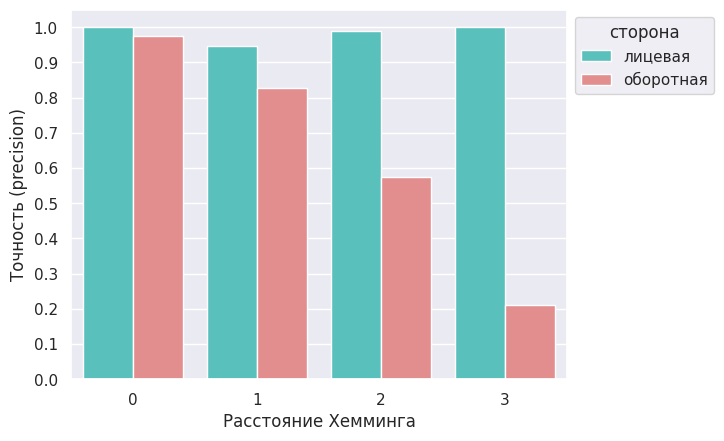

In [ ]:
ax = sns.barplot(data=stats, x='hash_dist', y='precision', hue='сторона', 
            palette=['mediumturquoise', 'lightcoral']);
plt.yticks(np.arange(0, 1.1, 0.1));
plt.ylabel('Точность (precision)');
plt.xlabel('Расстояние Хемминга');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));